In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import os
import time
from sklearn.utils.class_weight import compute_class_weight
import random
from tqdm import tqdm

In [24]:
def plot_metrics(train, val, test, epochs, title):
    """
    Plot the training, validation, and test metrics.

    Parameters:
        - train_loss (list): Training metric
        - val_loss (list): Validation metric
        - test_loss (list): Test tmetric
        - epochs (int): The number of epochs.
    """
    sns.set_theme(style="whitegrid", palette="pastel")
    plt.figure(figsize=(8, 8))
    plt.plot(range(1, epochs + 1), train, label='Training', color=sns.color_palette("pastel")[0])
    plt.plot(range(1, epochs + 1), val, label='Validation', color=sns.color_palette("pastel")[1])
    plt.plot(range(1, epochs + 1), test, label='Test', color=sns.color_palette("pastel")[2])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"{title}")
    plt.legend()
    plt.show()

In [25]:
class DataSampler:
    """
    DataSampler: Manages sampling and splitting of the USNW-NB15 dataset. Returns a training, validation, and test set.

    Initialisation:
        - train (None): The attributes that stores the train set.
        - val (None): The attributes that stores the validation set.
        - test (None): The attributes that stores the test set.
    """

    def __init__(self):
        self.train = None
        self.val = None
        self.test = None

    def sample_data(self, data, size, rs):
        """
        sample_data: Combines the USNW-NB15 1, 2, 3, 4 sets, does some basic cleaning, Use a random number generator to take slices for the validation
        and test set from the main data then splits into train, validation, and test set. Downsamples the data so that Normal labels match Generic in each set.
        Uses a mask to take only Normal values that do not precede a Non-Normal value.

        Parameters:
            - data (string): The dataset to use (currently only USNW-NB15 is supported).
            - type_of (string):  The type of sampling.
            - rs (int): The random seed for slicing operation.

        NOTE: Includes print outs to verify the process.
        """

        if data == 'full_data':
            feature_names = pd.read_csv('features2.csv' )

            print('Set1')
            feature_names_list = feature_names['Name'].tolist()
            s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
            s1.columns = feature_names_list
            s1.loc[s1['attack_cat'].isnull(), 'attack_cat'] = 'Normal'
            print(s1['attack_cat'].value_counts())
            print('Set2')
            feature_names_list = feature_names['Name'].tolist()
            s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)
            s2.columns = feature_names_list
            s2.loc[s2['attack_cat'].isnull(), 'attack_cat'] = 'Normal'
            print(s2['attack_cat'].value_counts())
            print('Set3')
            feature_names_list = feature_names['Name'].tolist()
            s3 = pd.read_csv('UNSW-NB15_3.csv', header=None)
            s3.columns = feature_names_list
            s3.loc[s3['attack_cat'].isnull(), 'attack_cat'] = 'Normal'
            print(s3['attack_cat'].value_counts())
            print('Set4')
            feature_names_list = feature_names['Name'].tolist()
            s4 = pd.read_csv('UNSW-NB15_4.csv', header=None)
            s4.columns = feature_names_list
            s4.loc[s4['attack_cat'].isnull(), 'attack_cat'] = 'Normal'
            print(s4['attack_cat'].value_counts())
            data = [s1, s2, s3, s4]
            i = 0

            while i < len(data):
                df = data[i]
                print(f"Set{i + 1}")
                normal = df[df['attack_cat'] == 'Normal'].shape[0]
                generic = df[df['attack_cat'] == 'Generic'].shape[0]
                difference = normal - generic
                mask = df['Label'].shift(-1) != 1
                rows = df[(df['attack_cat'] == 'Normal') & mask]
                downsampled = rows.sample(n=difference, random_state=rs)
                df2 = df.drop(downsampled.index)
                print(df2['attack_cat'].value_counts())
                data[i] = df2
                i += 1
            # Clean Labels.
            full_data = pd.concat([data[0], data[1], data[2], data[3]]).reset_index(drop=True)
            full_data['attack_cat'] = full_data['attack_cat'].str.replace(r'\s+', '', regex=True)
            full_data['attack_cat'] = full_data['attack_cat'].str.replace('Backdoors', 'Backdoor')
            # Drop Sparse Data.
            # NOTE: These values could also be transformed by adding 1 and setting nulls to 0.
            full_data = full_data.drop(columns=['ct_ftp_cmd', 'ct_flw_http_mthd', 'is_ftp_login'])
            # Remove error values created by nulls.
            full_data['sport'] = full_data['sport'].apply(pd.to_numeric)
            full_data = full_data[~full_data['dsport'].astype(str).str.startswith('0x')]
            full_data['dsport'] = full_data['dsport'].apply(pd.to_numeric)

            slice_size = int(size * len(full_data))
            val_start = random.randrange(0, len(full_data) - 2 * slice_size)
            val_end = val_start + slice_size
            val_data = full_data.iloc[val_start:val_end]
            df = full_data.drop(val_data.index)
            test_start = random.randrange(0, len(df) - slice_size)
            test_end = test_start + slice_size
            test_data = df.iloc[test_start:test_end]
            train_data = df.drop(test_data.index)
            print('Train')
            print(len(train_data))
            print('Val')
            print(len(val_data))
            print('Test')
            print(len(test_data))
            
            return train_data, val_data, test_data

In [26]:
class DataManager:
    """
    DataManager: Help manage the pre-processing of the USNW-NB15 dataset for an LSTM.

    Initialisation:
        - train (pd.Dataframe): The training data.
        - val (pd.Dataframe): The validation data.
        - test (pd.Dataframe): The teting data.
        - type_of (string): Specify if multiclass or other (currently only multi-class is supported).
    """
    def __init__(self, train, val, test, type_of):
        self.train = train
        self.val = val
        self.test = test
        if type_of == 'multi':
            for i in [self.train, self.val, self.test]:
                i.drop(columns=['Label'], inplace=True)    
            self.label = 'attack_cat'
        
    def label_encode(self):
        """
        label_encode: label encodes the categorical columns. Preset to 'proto', 'state', and 'service' and the label.

        NOTE: This can have conflicts depending on what seed is used in the sampler.

        """

        data = [self.train, self.val, self.test]
        columns = ['srcip', 'dstip', 'proto', 'state', 'service', self.label]
        encoder = LabelEncoder()
        for col in columns:
            for df in data:
                df[col] = encoder.fit_transform(df[col])
        self.train, self.val, self.test = data
    
    def onehot_encode(self):
        """
        onehot_encode: One-hot encodes the categorical columns. Preset to 'proto', 'state', and 'service'. Label encodes the target.

        NOTE: This can have conflicts depending on what seed is used in the sampler.
        """
        columns = ['srcip', 'dstip', 'proto', 'state', 'service']

        encoder2 = LabelEncoder()
        encoder = OneHotEncoder(sparse_output=False, dtype='float32')

        for col in columns:
            encoded_train = encoder.fit_transform(self.train[[col]])
            encoded_val = encoder.transform(self.val[[col]])
            encoded_test = encoder.transform(self.test[[col]])
            encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out([col]), index=self.train.index)
            encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out([col]), index=self.val.index)
            encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out([col]), index=self.test.index)
            self.train = pd.concat([self.train.drop(columns=[col]), encoded_train_df], axis=1)
            self.val = pd.concat([self.val.drop(columns=[col]), encoded_val_df], axis=1)
            self.test = pd.concat([self.test.drop(columns=[col]), encoded_test_df], axis=1)

        encoder = LabelEncoder()
        for df in [self.train, self.val, self.test]:
            df[self.label] = encoder.fit_transform(df[self.label])


    def standardise(self, type_of):
        """
        standardise: Standardises the features of the train and test datasets.

        Parameters:
            - type_of (string): Choose the standardisation ('standard' or 'minmax').
        """
        train_features = self.train.drop(columns=[self.label])
        val_features = self.val.drop(columns=[self.label])
        test_features = self.test.drop(columns=[self.label])
        train_label = self.train[self.label]
        val_label = self.val[self.label]
        test_label = self.test[self.label]
        if type_of == 'minmax':
            scaler = MinMaxScaler()
        elif type_of == 'standard':
            scaler = StandardScaler()
        scaled_train = scaler.fit_transform(train_features)
        scaled_val = scaler.transform(val_features)
        scaled_test = scaler.transform(test_features)
        self.train = pd.DataFrame(scaled_train, columns=train_features.columns, index=self.train.index)
        self.train[self.label] = train_label
        self.val = pd.DataFrame(scaled_val, columns=val_features.columns, index=self.val.index)
        self.val[self.label] = val_label
        self.test = pd.DataFrame(scaled_test, columns=test_features.columns, index=self.test.index)
        self.test[self.label] = test_label

    def get_sequence(self, batch_size):
        """
        get_sequence: Converts the Dtaframe to a sequence for each row and the corresponding label.
        
        Parameters:
            - batch_size (int): The batch size to use in DataLoader.

        Returns:
            - train_loader (DataLoader): Dataloader for the training data.
            - val_loader (DataLoader): Dataloader for the validation data.
            - test_loader (DataLoader): Dataloader for the test data.
        """
        
        train_seq = torch.tensor(self.train.drop(columns=[self.label]).values, dtype=torch.float32)
        val_seq = torch.tensor(self.val.drop(columns=[self.label]).values, dtype=torch.float32)
        test_seq = torch.tensor(self.test.drop(columns=[self.label]).values, dtype=torch.float32)
        train_label = torch.tensor(self.train[self.label].values, dtype=torch.long)
        val_label = torch.tensor(self.val[self.label].values, dtype=torch.long)
        test_label = torch.tensor(self.test[self.label].values, dtype=torch.long)

        # Add dimension for LSTM.
        train_seq = train_seq.unsqueeze(1)
        val_seq = val_seq.unsqueeze(1)
        test_seq = test_seq.unsqueeze(1)

        train_dataset = TensorDataset(train_seq, train_label)
        val_dataset = TensorDataset(val_seq, val_label)
        test_dataset = TensorDataset(test_seq, test_label)
        # NOTE: The batches are shuffled between themselves but the data sequences within remain the same.
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader, test_loader
    
    def get_weights(self, type_of):
        """
        get_weights: Calculate the weights of the labels for the given dataset. Used in Cross Entropy Loss criterion.
        
        Parameters:
            - type_of (string): The dataset to use (train, val, test).

        Returns:
            - class_weights (tensor): The class weights for the label.
        """
        if type_of == 'train':
            data = self.train
        elif type_of == 'val':
            data = self.val
        elif type_of == 'test':
            data = self.test
        labels = data[self.label].values
        class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
        return torch.tensor(class_weights, dtype=torch.float)

In [27]:
class SimpleLSTM(nn.Module):
    """
    SimpleLSTM: An LSTM Model customised for the USNW-NB15 dataset. Uses a fully connected layer to output the predictions.

    Parameters:
        - nn.Module (nn.Module): The torch Neural Network module.
    
    Initialisation:
        - n_features (int): Number of features:
        - hidden_size (int): Hidden layer size.
        - n_layers (int): Number of hidden layers.
        - n_labels (int): Number of labels.
    """
    def __init__(self, n_features, hidden_size, n_layers, n_labels, criterion, learning_rate):
        super(SimpleLSTM, self).__init__()
        # LSTM Layer (doubled).
        self.lstm = nn.LSTM(n_features, 
                            hidden_size, 
                            n_layers, 
                            batch_first=True)
        # Fully connected layer to the number of labels.
        self.fc = nn.Linear(hidden_size, n_labels)
        self.learning_rate = learning_rate
        self.optimizer = None
        self.criterion = criterion
        self.save_dir = 'saved_model/lstm/'
        # Metrics to track
        self.loss = []
        self.accuracy = []
        self.f1 = []
        self.epoch_time = []
        self.val_loss = []
        self.val_accuracy = []
        self.test_loss = []
        self.test_accuracy = []

    def forward(self, x):
        """
        forward: The forward function for calls the lstm layer and collects the last hidden state. 
        Finally uses a fully connected layer to output the logits for softmax.

        Parameters:
            - x (array): The batch array from the Dataloader.

        Returns:
            - out (array): The logits (10) of the fully connected layer.

        NOTE: We are using row-by to same label sequence.
        """
        lstm_out, (hn, cn) = self.lstm(x)
        # The last hidden state.
        final_hidden_state = hn[-1]
        # Fully connected to label count.
        out = self.fc(final_hidden_state)
        return out

    def run(self, train_loader, val_loader, test_loader, epochs, save_factor):
        """
        run: Go through each epoch and do a forward pass then backpropagate using Cross Entropy Loss and Adam Optimiser to adjust the gradient. 
        Then evaluate the epoch using a validation set. At the end of all epochs, evaluate using the test set.

        Parameters:
            - train_loader (Dataloader): The Dataloader with the training set and labels.
            - val_loader (Dataloader): The Dataloader with the validation set and labels.
            - test_loader (Dataloader): The Dataloader with the test set and labels.
            - epochs (int): The number of epochs to train.
            - save_factor (int): The factor at which epoch to save the model weights.
        """
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        for epoch in range(epochs):
            start_time = time.time()
            # Set to training mode.
            self.train()
            # Reset metrics for epoch.
            running_loss = 0.0
            correct = 0
            total = 0
            all_preds = []
            all_labels = []
            with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as tqmbar:
                for batch_idx, (inputs, labels) in enumerate(tqmbar):
                    inputs, labels = inputs.to(device), labels.to(device)
                    # Reset gradient.
                    self.optimizer.zero_grad()
                    # Forward.
                    outputs = self(inputs)
                    loss = self.criterion(outputs, labels)
                    # Backpropagation.
                    loss.backward()
                    self.optimizer.step()
                    # Cumulative loss.
                    running_loss += loss.item()
                    # Get highest probability label.
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            avg_loss = running_loss / len(train_loader)
            accuracy = 100 * correct / total
            if len(all_preds) > 0:
                f1 = f1_score(all_labels, all_preds, average='weighted')
            else:
                f1 = 0
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.2f}")
            self.loss.append(avg_loss)
            self.accuracy.append(accuracy)
            self.f1.append(f1)
            self.epoch_time.append(time.time() - start_time)

            # Validation after each epoch
            val_loss, val_accuracy, val_f1 = self.validate(val_loader)
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation F1 Score: {val_f1:.2f}")
            self.val_loss.append(val_loss)
            self.val_accuracy.append(val_accuracy)

            # Test after each epoch
            test_loss, test_accuracy, test_f1 = self.test(test_loader)
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1 Score: {test_f1:.2f}")
            self.test_loss.append(test_loss)
            self.test_accuracy.append(test_accuracy)

            # Save model at specified intervals.
            if (epoch + 1) % save_factor == 0:
                self.save_model(epoch + 1)

    def validate(self, data_loader):
        """
        validate: The validation run of the LSTM model.

        Parameters:
            - data_loader (Dataloader): The Dataloader of validation set.
        
        Returns:
            - loss (float): The average loss of the validation run.
            - accuracy (float): The accuracy of validation run.
            - f1 (float): The F1 score (macro) of validation run.
        """
        self.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        avg_loss = running_loss / len(data_loader)
        accuracy = 100 * correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')
        return avg_loss, accuracy, f1

    def test(self, test_loader):
        """
        test: The test run of the LSTM model.

        Parameters:
            - data_loader (Dataloader): The Dataloader of test set.
        
        Returns:
            - loss (float): The average loss of the test run.
            - accuracy (float): The accuracy of test run.
            - f1 (float): The F1 score (macro) of test run.
        """
        self.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_loss = running_loss / len(test_loader)
        accuracy = 100 * correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')
        return avg_loss, accuracy, f1

    def predict(self, input_data):
        """
        predict: Predicts the class for the input.

        Parameters:
            - input_data (tensor): The input data.
        
        Returns:
            - predicted (tensor): The predicted labels.
        """
        self.eval()
        input_data = input_data.to(device)
        with torch.no_grad():
            output = self(input_data)
            _, predicted = torch.max(output, 1)
        return predicted

    def save_model(self, epoch):
        """
        save_model: Save the model's state and metrics to directory for the given epoch.

        Parameters:
            - epoch (int): The current epoch.
        """
        checkpoint_path = os.path.join(self.save_dir, f"lstm_epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.criterion,
        }, checkpoint_path)
        print(f"Model saved to {checkpoint_path}")

    def load_model(self, epoch):
        """
        load_model: Load a saved model from the directory.

        Parameters:
            - epoch (int): The epoch to load.
    
        """
        checkpoint_path = os.path.join(self.save_dir, f"lstm_epoch_{epoch}.pt")
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            self.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [28]:
df = DataSampler()
# Type of data, proportion for slices, random seed.
train_data, val_data, test_data = df.sample_data('full_data', 0.2, 42)

Set1


C:\Users\adi_s\AppData\Local\Temp\ipykernel_21824\2982480039.py:35: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)


attack_cat
Normal            677786
Generic             7522
Exploits            5409
 Fuzzers            5051
Reconnaissance      1759
DoS                 1167
Backdoors            534
Analysis             526
Shellcode            223
Worms                 24
Name: count, dtype: int64
Set2


C:\Users\adi_s\AppData\Local\Temp\ipykernel_21824\2982480039.py:41: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


attack_cat
Normal              647252
Generic              27883
Exploits             11103
 Fuzzers              4668
DoS                   4637
 Reconnaissance       3116
Analysis               608
Backdoor               370
 Shellcode             324
Worms                   40
Name: count, dtype: int64
Set3
attack_cat
Normal              542576
Generic             118198
Exploits             16574
 Fuzzers              9137
DoS                   5642
 Reconnaissance       5582
Analysis               873
Backdoor               759
 Shellcode             593
Worms                   67
Name: count, dtype: int64
Set4
attack_cat
Normal              351150
Generic              61878
Exploits             11439
 Fuzzers              5390
DoS                   4907
 Reconnaissance       3530
Analysis               670
Backdoor               666
 Shellcode             371
Worms                   43
Name: count, dtype: int64
Set1
attack_cat
Normal            7522
Generic           7522
Exploit

In [29]:
dm = DataManager(train_data, val_data, test_data, 'multi')
dm.label_encode()
dm.standardise('minmax')
train_loader, val_loader, test_loader = dm.get_sequence(32)

In [30]:
#device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_features = 44
hidden_size = 128
n_layers = 2
n_labels = 10
# Weights have not been tried on this dataset and model.
#weights = dm.get_weights('train')
model = SimpleLSTM(n_features, hidden_size, n_layers, n_labels, nn.CrossEntropyLoss(), 0.001).to(device)
# Datasets, Epochs, and Save Factor.
# NOTE: Save Factor is set above epochs as models state_dict can be large in size.
model.run(train_loader, val_loader, test_loader, 20, 100)

Epoch 1/20: 100%|██████████| 10064/10064 [00:27<00:00, 360.01batch/s]


Epoch [1/20], Loss: 0.3128, Accuracy: 89.08%, F1 Score: 0.88
Validation Loss: 0.1947, Validation Accuracy: 92.79%, Validation F1 Score: 0.93
Test Loss: 0.2016, Test Accuracy: 92.37%, Test F1 Score: 0.93


Epoch 2/20: 100%|██████████| 10064/10064 [00:28<00:00, 349.74batch/s]


Epoch [2/20], Loss: 0.2498, Accuracy: 90.80%, F1 Score: 0.90
Validation Loss: 0.1844, Validation Accuracy: 93.00%, Validation F1 Score: 0.92
Test Loss: 0.1895, Test Accuracy: 93.15%, Test F1 Score: 0.93


Epoch 3/20: 100%|██████████| 10064/10064 [00:26<00:00, 378.70batch/s]


Epoch [3/20], Loss: 0.2389, Accuracy: 91.07%, F1 Score: 0.90
Validation Loss: 0.1854, Validation Accuracy: 92.89%, Validation F1 Score: 0.93
Test Loss: 0.1915, Test Accuracy: 92.42%, Test F1 Score: 0.93


Epoch 4/20: 100%|██████████| 10064/10064 [00:26<00:00, 380.69batch/s]


Epoch [4/20], Loss: 0.2315, Accuracy: 91.28%, F1 Score: 0.91
Validation Loss: 0.1951, Validation Accuracy: 92.66%, Validation F1 Score: 0.93
Test Loss: 0.2048, Test Accuracy: 92.19%, Test F1 Score: 0.92


Epoch 5/20: 100%|██████████| 10064/10064 [00:27<00:00, 370.84batch/s]


Epoch [5/20], Loss: 0.2259, Accuracy: 91.44%, F1 Score: 0.91
Validation Loss: 0.1795, Validation Accuracy: 93.25%, Validation F1 Score: 0.92
Test Loss: 0.1860, Test Accuracy: 93.51%, Test F1 Score: 0.93


Epoch 6/20: 100%|██████████| 10064/10064 [00:26<00:00, 384.38batch/s]


Epoch [6/20], Loss: 0.2221, Accuracy: 91.54%, F1 Score: 0.91
Validation Loss: 0.1736, Validation Accuracy: 93.34%, Validation F1 Score: 0.92
Test Loss: 0.1774, Test Accuracy: 93.67%, Test F1 Score: 0.93


Epoch 7/20: 100%|██████████| 10064/10064 [00:27<00:00, 361.00batch/s]


Epoch [7/20], Loss: 0.2189, Accuracy: 91.65%, F1 Score: 0.91
Validation Loss: 0.1703, Validation Accuracy: 93.37%, Validation F1 Score: 0.93
Test Loss: 0.1743, Test Accuracy: 93.32%, Test F1 Score: 0.93


Epoch 8/20: 100%|██████████| 10064/10064 [00:27<00:00, 367.07batch/s]


Epoch [8/20], Loss: 0.2166, Accuracy: 91.70%, F1 Score: 0.91
Validation Loss: 0.1676, Validation Accuracy: 93.51%, Validation F1 Score: 0.93
Test Loss: 0.1706, Test Accuracy: 93.41%, Test F1 Score: 0.93


Epoch 9/20: 100%|██████████| 10064/10064 [00:27<00:00, 364.36batch/s]


Epoch [9/20], Loss: 0.2142, Accuracy: 91.79%, F1 Score: 0.91
Validation Loss: 0.1667, Validation Accuracy: 93.46%, Validation F1 Score: 0.93
Test Loss: 0.1721, Test Accuracy: 93.06%, Test F1 Score: 0.93


Epoch 10/20: 100%|██████████| 10064/10064 [00:27<00:00, 360.00batch/s]


Epoch [10/20], Loss: 0.2120, Accuracy: 91.84%, F1 Score: 0.91
Validation Loss: 0.1983, Validation Accuracy: 92.68%, Validation F1 Score: 0.92
Test Loss: 0.2059, Test Accuracy: 92.16%, Test F1 Score: 0.92


Epoch 11/20: 100%|██████████| 10064/10064 [00:26<00:00, 378.92batch/s]


Epoch [11/20], Loss: 0.2101, Accuracy: 91.89%, F1 Score: 0.91
Validation Loss: 0.1703, Validation Accuracy: 93.44%, Validation F1 Score: 0.93
Test Loss: 0.1764, Test Accuracy: 92.83%, Test F1 Score: 0.93


Epoch 12/20: 100%|██████████| 10064/10064 [00:26<00:00, 375.10batch/s]


Epoch [12/20], Loss: 0.2085, Accuracy: 91.92%, F1 Score: 0.91
Validation Loss: 0.1680, Validation Accuracy: 93.44%, Validation F1 Score: 0.93
Test Loss: 0.1723, Test Accuracy: 92.87%, Test F1 Score: 0.93


Epoch 13/20: 100%|██████████| 10064/10064 [00:26<00:00, 377.57batch/s]


Epoch [13/20], Loss: 0.2072, Accuracy: 91.96%, F1 Score: 0.92
Validation Loss: 0.1768, Validation Accuracy: 93.15%, Validation F1 Score: 0.93
Test Loss: 0.1842, Test Accuracy: 92.56%, Test F1 Score: 0.93


Epoch 14/20: 100%|██████████| 10064/10064 [00:28<00:00, 352.38batch/s]


Epoch [14/20], Loss: 0.2056, Accuracy: 92.00%, F1 Score: 0.92
Validation Loss: 0.1736, Validation Accuracy: 93.18%, Validation F1 Score: 0.92
Test Loss: 0.1787, Test Accuracy: 92.58%, Test F1 Score: 0.93


Epoch 15/20: 100%|██████████| 10064/10064 [00:26<00:00, 373.17batch/s]


Epoch [15/20], Loss: 0.2046, Accuracy: 92.04%, F1 Score: 0.92
Validation Loss: 0.2026, Validation Accuracy: 92.82%, Validation F1 Score: 0.92
Test Loss: 0.2120, Test Accuracy: 92.35%, Test F1 Score: 0.92


Epoch 16/20: 100%|██████████| 10064/10064 [00:26<00:00, 379.33batch/s]


Epoch [16/20], Loss: 0.2032, Accuracy: 92.07%, F1 Score: 0.92
Validation Loss: 0.1881, Validation Accuracy: 93.04%, Validation F1 Score: 0.93
Test Loss: 0.1945, Test Accuracy: 92.40%, Test F1 Score: 0.93


Epoch 17/20: 100%|██████████| 10064/10064 [00:27<00:00, 370.27batch/s]


Epoch [17/20], Loss: 0.2021, Accuracy: 92.15%, F1 Score: 0.92
Validation Loss: 0.1740, Validation Accuracy: 93.35%, Validation F1 Score: 0.94
Test Loss: 0.1798, Test Accuracy: 92.82%, Test F1 Score: 0.93


Epoch 18/20: 100%|██████████| 10064/10064 [00:26<00:00, 383.79batch/s]


Epoch [18/20], Loss: 0.2011, Accuracy: 92.16%, F1 Score: 0.92
Validation Loss: 0.1616, Validation Accuracy: 93.70%, Validation F1 Score: 0.94
Test Loss: 0.1652, Test Accuracy: 93.25%, Test F1 Score: 0.94


Epoch 19/20: 100%|██████████| 10064/10064 [00:25<00:00, 389.94batch/s]


Epoch [19/20], Loss: 0.2001, Accuracy: 92.20%, F1 Score: 0.92
Validation Loss: 0.1634, Validation Accuracy: 93.59%, Validation F1 Score: 0.94
Test Loss: 0.1664, Test Accuracy: 93.13%, Test F1 Score: 0.93


Epoch 20/20: 100%|██████████| 10064/10064 [00:25<00:00, 387.31batch/s]


Epoch [20/20], Loss: 0.1990, Accuracy: 92.22%, F1 Score: 0.92
Validation Loss: 0.1728, Validation Accuracy: 93.38%, Validation F1 Score: 0.93
Test Loss: 0.1764, Test Accuracy: 93.21%, Test F1 Score: 0.93


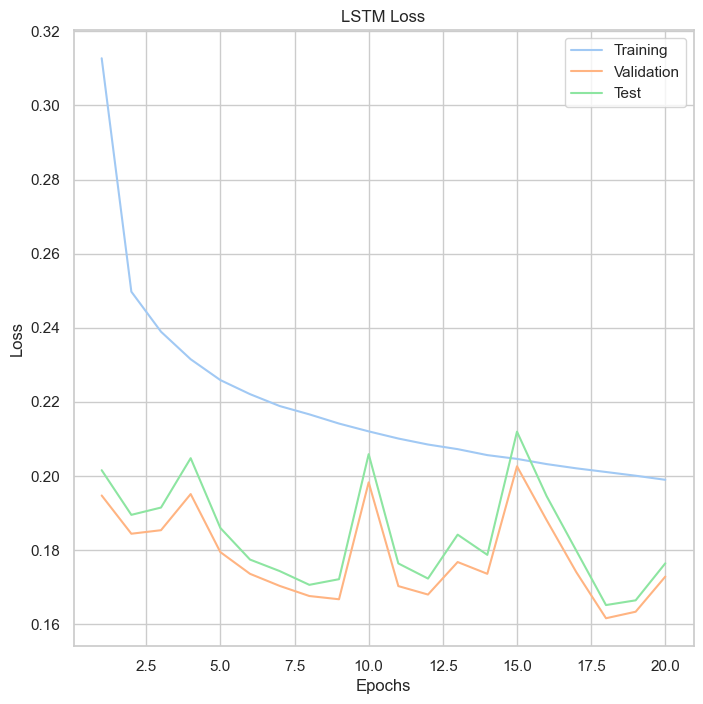

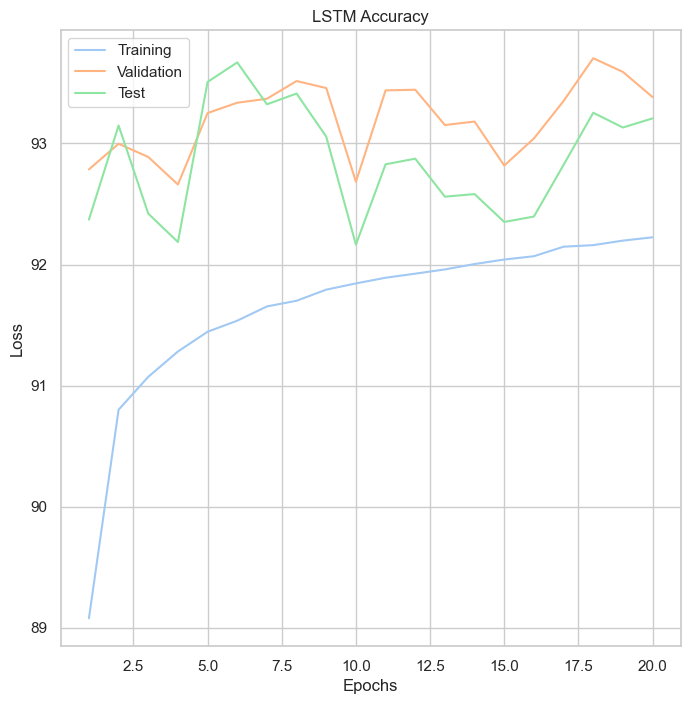

In [31]:
plot_metrics(model.loss, model.val_loss, model.test_loss, 20, 'LSTM Loss')
plot_metrics(model.accuracy, model.val_accuracy, model.test_accuracy, 20, 'LSTM Accuracy')